## Relevant Code Files and Dataset
https://drive.google.com/drive/folders/1_W77nIU02LBCVpb3NH-_1S3oxYWT-MPu?usp=sharing

In [1]:
import matplotlib.pyplot as plt
from PIL import Image 
import seaborn as sns
import numpy as np
import pandas as pd
import os
from tensorflow.keras.utils import to_categorical
from glob import glob
import cv2
from tensorflow.keras import backend as K

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


IMAGE_SIZE = (224,224)
BATCH_SIZE = 32

train_dir = 'dataSet/Train'
test_dir = 'dataSet/Test'

train_datagen = ImageDataGenerator(rescale = 1/255)
test_datagen = ImageDataGenerator(rescale = 1/255)

print("Training Images")
train_data = train_datagen.flow_from_directory(train_dir, target_size = IMAGE_SIZE, batch_size = BATCH_SIZE, class_mode = "categorical", shuffle=True)

print("Testing Images")
test_data = test_datagen.flow_from_directory(test_dir, target_size = IMAGE_SIZE, batch_size = BATCH_SIZE, class_mode = "categorical", shuffle = True)

Training Images
Found 9013 images belonging to 7 classes.
Testing Images
Found 1002 images belonging to 7 classes.


In [3]:
labels = {value: key for key, value in train_data.class_indices.items()}

for key, value in labels.items():
    print(f"{key} : {value}")

0 : akiec
1 : bcc
2 : bkl
3 : df
4 : mel
5 : nv
6 : vasc


In [4]:
lesion_type_dict = {
    5: 'Melanocytic nevi',
    4: 'Melanoma',
    2: 'Benign keratosis-like lesions ',
    1: 'Basal cell carcinoma',
    0: 'Actinic keratoses',
    6: 'Vascular lesions',
    3: 'Dermatofibroma'
}

labels.update(lesion_type_dict)

In [5]:
from tensorflow.keras import backend as K

def sensitivity(y_true,y_pred):
    true_positives=tf.reduce_sum(tf.round(K.clip(y_true*y_pred, 0, 1)))
    possible_positives=tf.reduce_sum(tf.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives+K.epsilon())

def specificity(y_true,y_pred):
    true_negatives=tf.reduce_sum(K.round(K.clip((1-y_true)*(1-y_pred), 0, 1)))
    possible_negatives=tf.reduce_sum(K.round(K.clip((1-y_true), 0, 1)))
    return true_negatives / (possible_negatives+K.epsilon())


def precision(y_true, y_pred):
    """ Precision metric. Only computes a batch-wise average of precision. Computes the precision, a metric for multi-label classification of
    how many selected items are relevant."""
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    """ Recall metric. Only computes a batch-wise average of recall. Computes the recall, a metric for multi-label classification of
    how many relevant items are selected. """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

In [6]:
import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

In [7]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

## Using transfer learning for MobileNet

In [10]:
mobilenet_url="https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

In [13]:
def create_model (model_url,num_classes=7):
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=True,
                                           name='feature_extraction_layer',
                                           input_shape = IMAGE_SIZE+(3,))
  model=tf.keras.Sequential([
                             feature_extractor_layer,
                             layers.Dense(num_classes,activation='softmax',name='output_layers')
  ])
  return model

In [14]:
mobilenet_model = create_model(mobilenet_url,num_classes = train_data.num_classes)
mobilenet_model.summary()
mobilenet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy',sensitivity, precision,recall,specificity])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             2257984   
 erasLayer)                                                      
                                                                 
 output_layers (Dense)       (None, 7)                 8967      
                                                                 
Total params: 2,266,951
Trainable params: 2,232,839
Non-trainable params: 34,112
_________________________________________________________________


In [16]:
EPOCHS = 30

mobilenet_history =mobilenet_model.fit(train_data,
                                  epochs=EPOCHS,
                                  steps_per_epoch=len(train_data),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  # Add TensorBoard callback to model (callbacks parameter takes a list)
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", # save experiment logs here
                                                                         experiment_name="mobilenet_net")])

Saving TensorBoard log files to: tensorflow_hub/mobilenet_net/20221021-190916
Epoch 1/30
282/282 [==============================] - 53s 185ms/step - loss: 0.7642 - accuracy: 0.7578 - sensitivity: 0.6773 - precision: 0.8408 - recall: 0.6773 - specificity: 0.9786 - val_loss: 1.1396 - val_accuracy: 0.7016 - val_sensitivity: 0.6979 - val_precision: 0.7212 - val_recall: 0.6979 - val_specificity: 0.9550
Epoch 2/30
282/282 [==============================] - 49s 173ms/step - loss: 0.6235 - accuracy: 0.8085 - sensitivity: 0.7614 - precision: 0.8581 - recall: 0.7614 - specificity: 0.9790 - val_loss: 0.9988 - val_accuracy: 0.6667 - val_sensitivity: 0.6150 - val_precision: 0.7216 - val_recall: 0.6150 - val_specificity: 0.9606
Epoch 3/30
282/282 [==============================] - 42s 149ms/step - loss: 0.5433 - accuracy: 0.8346 - sensitivity: 0.7992 - precision: 0.8710 - recall: 0.7992 - specificity: 0.9802 - val_loss: 0.7740 - val_accuracy: 0.7874 - val_sensitivity: 0.7691 - val_precision: 0.8203 

In [17]:
tf.keras.models.save_model(mobilenet_model, 'mobilenet_model.h5')

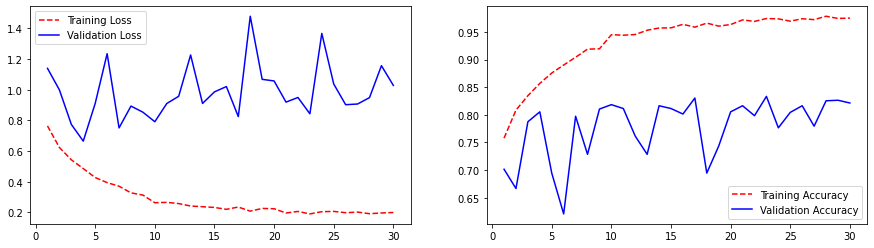

In [18]:
fig, axs = plt.subplots(1, 2, figsize = (15, 4))

training_loss = mobilenet_history.history['loss']
validation_loss = mobilenet_history.history['val_loss']

training_accuracy = mobilenet_history.history['accuracy']
validation_accuracy = mobilenet_history.history['val_accuracy']

epoch_count = range(1, len(training_loss) + 1)

axs[0].plot(epoch_count, training_loss, 'r--')
axs[0].plot(epoch_count, validation_loss, 'b-')
axs[0].legend(['Training Loss', 'Validation Loss'])

axs[1].plot(epoch_count, training_accuracy, 'r--')
axs[1].plot(epoch_count, validation_accuracy, 'b-')
axs[1].legend(['Training Accuracy', 'Validation Accuracy'])

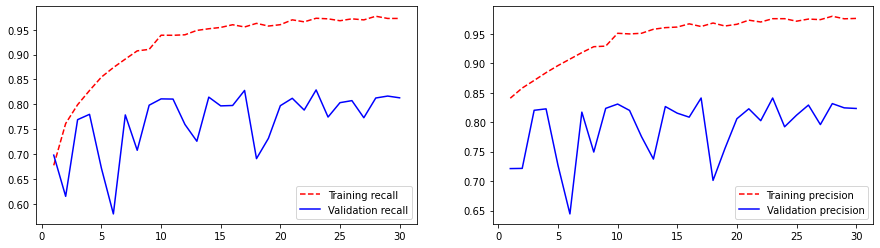

In [19]:
fig, axs = plt.subplots(1, 2, figsize = (15, 4))

training_recall = mobilenet_history.history['recall']
validation_recall = mobilenet_history.history['val_recall']
training_precision = mobilenet_history.history['precision']
validation_precision =mobilenet_history.history['val_precision']

epoch_count = range(1, len(training_loss) + 1)

axs[0].plot(epoch_count, training_recall, 'r--')
axs[0].plot(epoch_count, validation_recall, 'b-')
axs[0].legend(['Training recall', 'Validation recall'])

axs[1].plot(epoch_count, training_precision, 'r--')
axs[1].plot(epoch_count, validation_precision, 'b-')
axs[1].legend(['Training precision', 'Validation precision'])


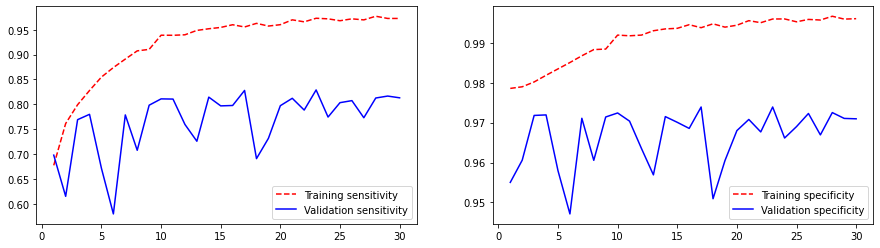

In [20]:
fig, axs = plt.subplots(1, 2, figsize = (15, 4))

training_mean_iou =mobilenet_history.history['sensitivity']
validation_mean_iou = mobilenet_history.history['val_sensitivity']

training_specificity = mobilenet_history.history['specificity']
validation_specificity = mobilenet_history.history['val_specificity']

epoch_count = range(1, len(training_loss) + 1)

axs[0].plot(epoch_count, training_mean_iou, 'r--')
axs[0].plot(epoch_count, validation_mean_iou, 'b-')
axs[0].legend(['Training sensitivity', 'Validation sensitivity'])

axs[1].plot(epoch_count, training_specificity, 'r--')
axs[1].plot(epoch_count, validation_specificity, 'b-')
axs[1].legend(['Training specificity', 'Validation specificity'])